In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import ks_2samp


In [2]:
results_folder = Path('~/azurefiles/projects/streamflow/ranking_model_results/2024-06-13-USGS_Stations').expanduser().resolve()
sites = sorted([s.name for s in results_folder.iterdir() if s.is_dir()], key=lambda s: s[3:])


In [3]:
def get_filenames_with_attribute(site_annots, attribute):
    """
    Filters the site annotations DataFrame for rows where either the left or right attributes
    column contains the specified attribute, and returns the unique filenames.
    """
    left_filtered = site_annots[site_annots['left.attributes'].str.contains(attribute, na=False)]['left.filename']
    right_filtered = site_annots[site_annots['right.attributes'].str.contains(attribute, na=False)]['right.filename']
    return pd.concat([left_filtered, right_filtered]).unique()

def get_filenames_with_nan(site_annots):
    """
    Filters the site annotations DataFrame for rows where either the left or right attributes
    column is NaN, and returns the unique filenames.
    """
    left_nan = site_annots[site_annots['left.attributes'].isna()]['left.filename']
    right_nan = site_annots[site_annots['right.attributes'].isna()]['right.filename']
    return pd.concat([left_nan, right_nan]).unique()

left.attributes
DRY             1855
DISCONNECTED     532
BAD                1
ICE_PARTIAL        1
Name: count, dtype: int64
right.attributes
DRY                 1832
DISCONNECTED         508
DISCONNECTED,DRY       1
ICE_PARTIAL,DRY        1
Name: count, dtype: int64
72-PA_04.5FL: KS test stat=0.937, p-val=0.000
left.attributes
DISCONNECTED    477
DRY              20
ICE_PARTIAL       8
BAD               1
Name: count, dtype: int64
right.attributes
DISCONNECTED    480
DRY              24
ICE_PARTIAL      13
Name: count, dtype: int64
75-PA_06.5FL: KS test stat=0.905, p-val=0.000
left.attributes
DISCONNECTED        443
ICE_PARTIAL          17
DRY                  15
BAD                   3
DISCONNECTED,DRY      1
Name: count, dtype: int64
right.attributes
DISCONNECTED    423
ICE_PARTIAL      23
DRY              19
BAD               5
Name: count, dtype: int64
46-PA_06FL: KS test stat=0.392, p-val=0.000
left.attributes
DISCONNECTED        379
DRY                 376
ICE_PARTIAL          

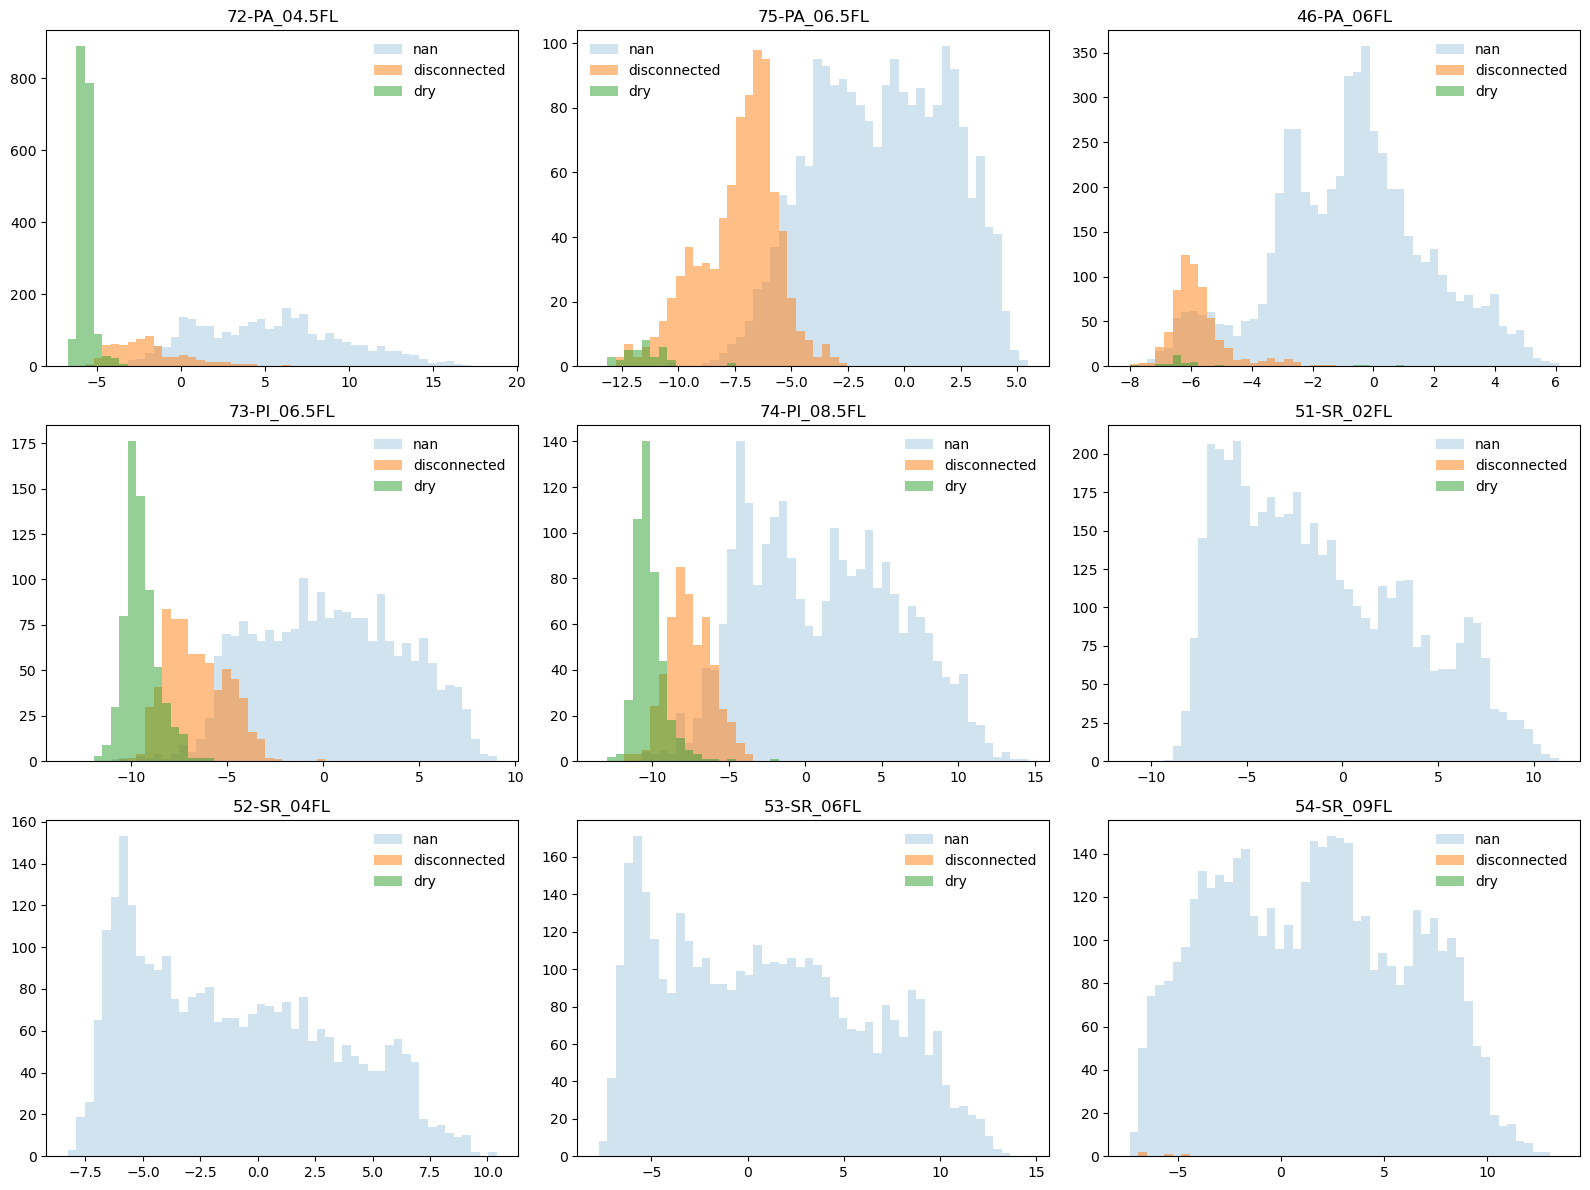

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, site in enumerate(sites):
    # Load the images, annotations, and predictions for the site
    site_results_folder = results_folder / site / 'RANK-FLOW-20240613'
    site_images = pd.read_csv(site_results_folder / 'input' / 'images.csv') 
    site_annots = pd.read_csv(site_results_folder / 'input' / 'annotations.csv')
    site_preds = pd.read_csv(site_results_folder / 'transform' / 'predictions.csv')

    # Look at the values in the 'left.attributes' and 'right.attributes' columns
    print(site_annots['left.attributes'].value_counts())
    print(site_annots['right.attributes'].value_counts())

    # Use the helper functions to get filenames for images with the 'DISCONNECTED' and 'DRY' attributes
    # and for images with NaN attributes (i.e. not flagged as 'DISCONNECTED' or 'DRY' or anything else)
    disconnected = get_filenames_with_attribute(site_annots, 'DISCONNECTED')
    dry = get_filenames_with_attribute(site_annots, 'DRY')
    nan = get_filenames_with_nan(site_annots)

    # Filter the predictions DataFrame to only include the filenames for the images with the specified attributes
    disconnected_preds = site_preds[site_preds['filename'].isin(disconnected)]
    dry_preds = site_preds[site_preds['filename'].isin(dry)]
    nan_preds = site_preds[site_preds['filename'].isin(nan)]

    # Plot histograms of the scores for the disconnected, dry, and NaN images
    bins = np.linspace(site_preds['score'].min(), site_preds['score'].max(), 51)
    ax[i // 3, i % 3].hist(nan_preds['score'], bins=bins, alpha=0.2, label='nan')
    ax[i // 3, i % 3].hist(disconnected_preds['score'], bins=bins, alpha=0.5, label='disconnected')
    ax[i // 3, i % 3].hist(dry_preds['score'], bins=bins, alpha=0.5, label='dry')
    ax[i // 3, i % 3].set_title(site)
    ax[i // 3, i % 3].legend(loc='best', frameon=False)

    # Check if dry vs disconnected scores are significantly different
    if len(disconnected_preds) > 0 and len(dry_preds) > 0:
        ks_stat, ks_pval = ks_2samp(disconnected_preds['score'], dry_preds['score'])
        print(f'{site}: KS test stat={ks_stat:.3f}, p-val={ks_pval:.3f}')

plt.tight_layout()


